# Solve the problem leveraging ResNet-50 architecture
In this notebook, we will use the ResNet-50 architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [5]:
from google.colab import drive
import os
import shutil

import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.applications.resnet_v2 import preprocess_input, decode_predictions

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [6]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/SplittedDataset.zip" -d "/content"

Mounted at /content/drive


## Set Parameters

In [7]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/resnet-101"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [10]:
def set_seed ():
  '''
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return: the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [11]:
set_seed()

In [12]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Feature extraction
Firstly, we use the pretrained network to extract feature and we define our classifiers to classify the images.

In [19]:

conv_base = tf.keras.applications.ResNet101V2(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

171317808/171317808 [==============================] - 1s 0us/step


In [20]:
conv_base.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [21]:
conv_base.trainable = False

### Experiment 1: one dense layer with 64 neurons
In this first experiment we try a simple configuration with a single dense layer before the output layer.

In [24]:
from keras.applications.densenet import preprocess_input
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                642259

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 1.4497 - accuracy: 0.6961
Epoch 1: val_loss improved from inf to 1.34021, saving model to /content/models/experiment1_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 65s 267ms/step - loss: 1.4497 - accuracy: 0.6961 - val_loss: 1.3402 - val_accuracy: 0.6459
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8419
Epoch 2: val_loss improved from 1.34021 to 0.91484, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 46s 229ms/step - loss: 0.4857 - accuracy: 0.8419 - val_loss: 0.9148 - val_accuracy: 0.7326
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2638 - accuracy: 0.8987
Epoch 3: val_loss improved from 0.91484 to 0.85323, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 47s 233ms/step - loss: 0.2638 - accuracy: 0.8987 - val_loss: 0.8532 - val_accuracy: 0.7364
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9375
Epoch 4: val_loss improved from 0.85323 to 0.62239, saving model to /conte

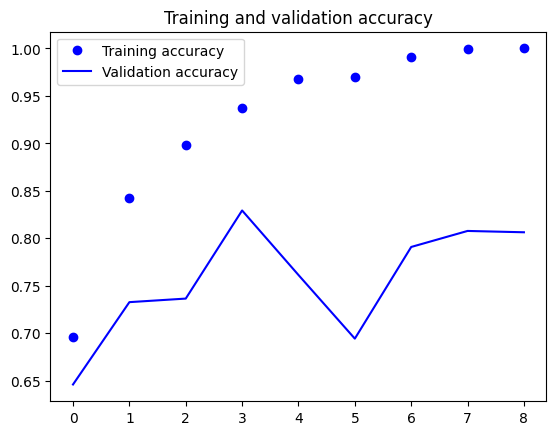

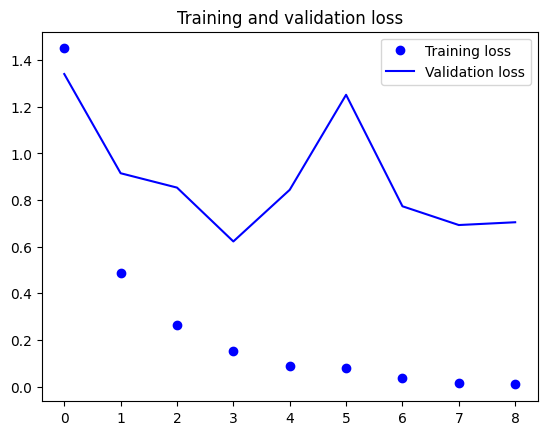

In [25]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30)

67/67 [==============================] - 15s 185ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6974    0.7615    0.7280       696
           1     0.8791    0.8399    0.8591      1437

    accuracy                         0.8143      2133
   macro avg     0.7882    0.8007    0.7935      2133
weighted avg     0.8198    0.8143    0.8163      2133



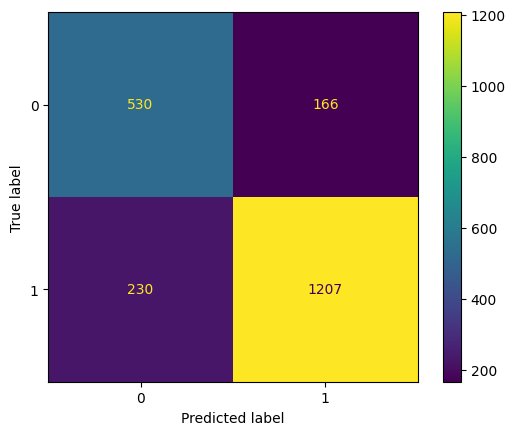

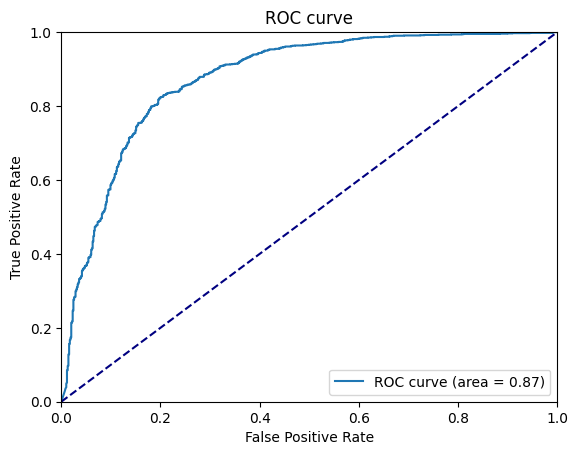

In [26]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

### Experiment 2: one dense layer with 32 neurons
We tried to lower the number of neurons, to fight overfitting

In [27]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)

x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu') (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 32)                3211

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.0985 - accuracy: 0.9692
Epoch 1: val_loss improved from inf to 0.72206, saving model to /content/models/experiment2_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 58s 289ms/step - loss: 0.0985 - accuracy: 0.9692 - val_loss: 0.7221 - val_accuracy: 0.8063
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9844
Epoch 2: val_loss did not improve from 0.72206
200/200 [==============================] - 54s 270ms/step - loss: 0.0672 - accuracy: 0.9844 - val_loss: 0.8433 - val_accuracy: 0.7871
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9873
Epoch 3: val_loss did not improve from 0.72206
200/200 [==============================] - 45s 226ms/step - loss: 0.0561 - accuracy: 0.9873 - val_loss: 0.8729 - val_accuracy: 0.8072
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9875
Epoch 4: val_loss did not improve from 0.72206
200/200 [==============================] - 45s 225ms/step - loss: 0.0545 - accuracy: 0.9875 - val_loss: 0.9877 - val_accuracy: 0.7795
Epoch 5/30
200/200 [===============

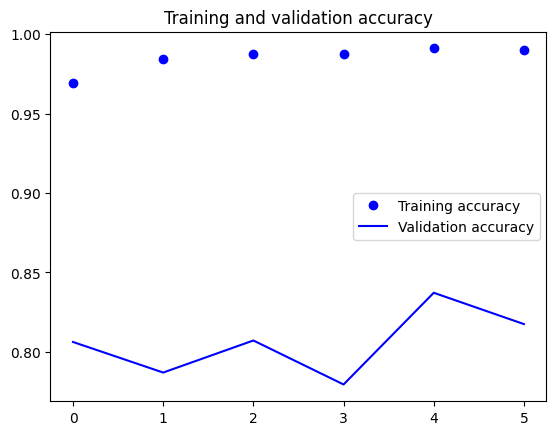

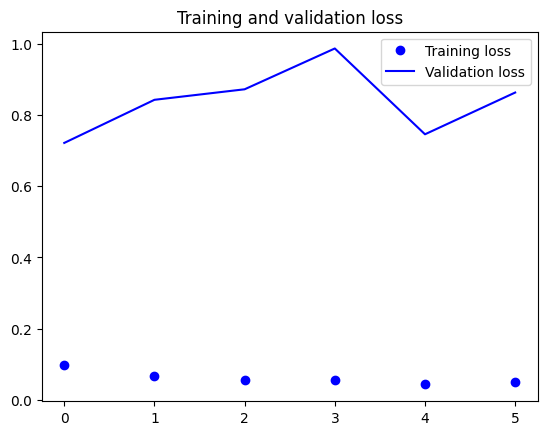

In [30]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30)

67/67 [==============================] - 13s 161ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6985    0.7457    0.7213       696
           1     0.8727    0.8441    0.8582      1437

    accuracy                         0.8120      2133
   macro avg     0.7856    0.7949    0.7897      2133
weighted avg     0.8158    0.8120    0.8135      2133



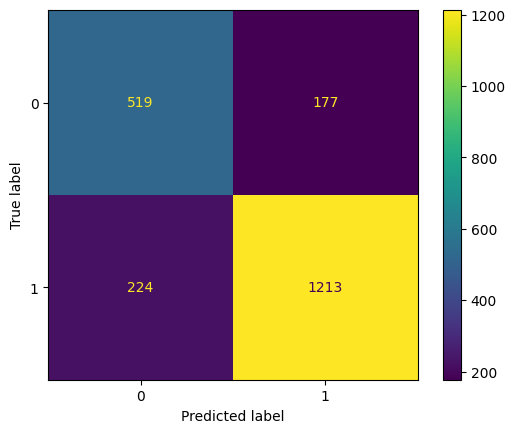

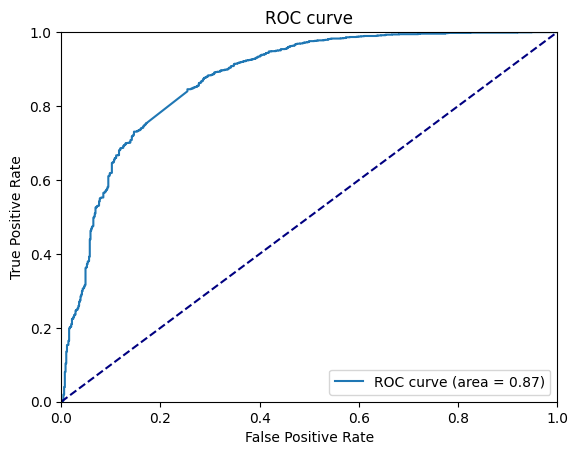

In [29]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

### Experiment 3: one dense layer with 64 neurons and dropout
Lowering the capacity of the networks leads us to underfitting, we could try to use Dropout instead.

In [31]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu') (x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                6422

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 1.3155 - accuracy: 0.6693
Epoch 1: val_loss improved from inf to 0.51521, saving model to /content/models/experiment3_feature_extraction.h5
200/200 [==============================] - 64s 283ms/step - loss: 1.3155 - accuracy: 0.6693 - val_loss: 0.5152 - val_accuracy: 0.7847
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.4835 - accuracy: 0.7436
Epoch 2: val_loss did not improve from 0.51521
200/200 [==============================] - 44s 217ms/step - loss: 0.4835 - accuracy: 0.7436 - val_loss: 0.5632 - val_accuracy: 0.7767
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.7708
Epoch 3: val_loss improved from 0.51521 to 0.38663, saving model to /content/models/experiment3_feature_extraction.h5
200/200 [==============================] - 45s 222ms/step - loss: 0.4346 - accuracy: 0.7708 - val_loss: 0.3866 - val_accuracy: 0.8330
Epoch 4/50
200/200 [===========

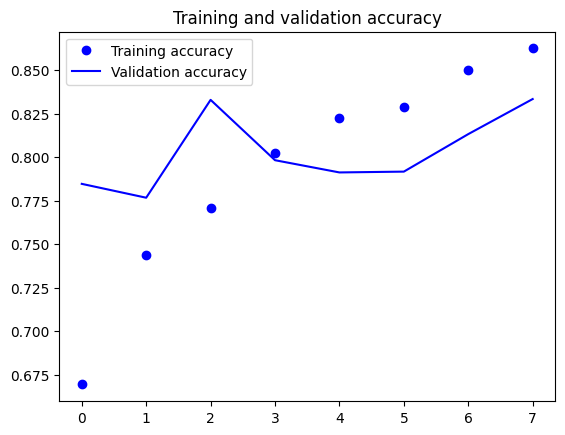

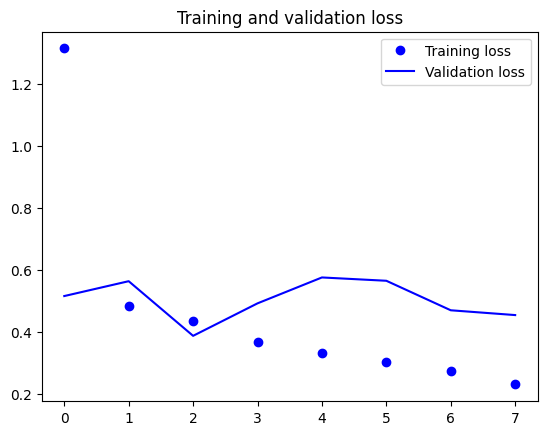

In [32]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50)

67/67 [==============================] - 13s 162ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8709    0.5718    0.6904       696
           1     0.8222    0.9589    0.8853      1437

    accuracy                         0.8326      2133
   macro avg     0.8465    0.7654    0.7878      2133
weighted avg     0.8381    0.8326    0.8217      2133



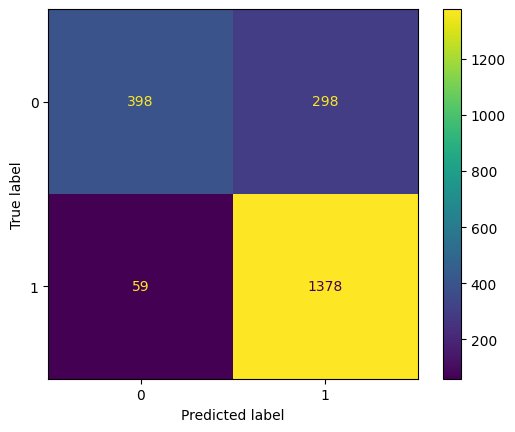

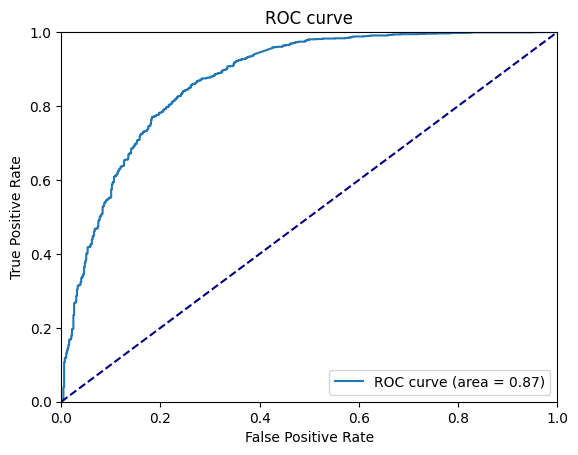

In [33]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))

### Experiment 4: global average pooling
Try GlobalAveragePooling instead of fully connected layers, to lower the number of parameters.

In [34]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.7001
Epoch 1: val_loss improved from inf to 0.58828, saving model to /content/models/experiment4_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 57s 241ms/step - loss: 0.5845 - accuracy: 0.7001 - val_loss: 0.5883 - val_accuracy: 0.6796
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7389
Epoch 2: val_loss improved from 0.58828 to 0.52130, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 47s 232ms/step - loss: 0.5222 - accuracy: 0.7389 - val_loss: 0.5213 - val_accuracy: 0.7425
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.4903 - accuracy: 0.7703
Epoch 3: val_loss improved from 0.52130 to 0.44993, saving model to /content/models/experiment4_feature_extraction.h5
200/200 [==============================] - 55s 275ms/step - loss: 0.4903 - accuracy: 0.7703 - val_loss: 0.4499 - val_accuracy: 0.8063
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.7752
Epoch 4: val_loss did not improve from 0.44993
200/200 [==================

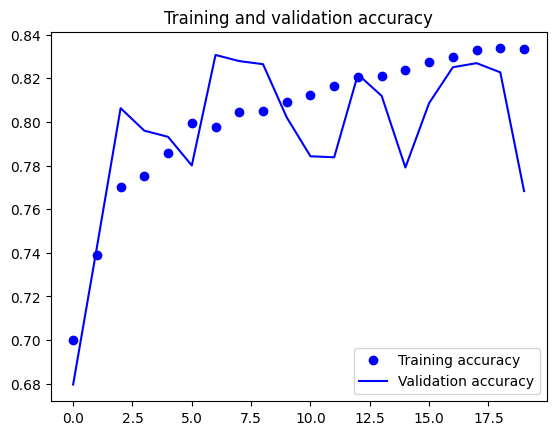

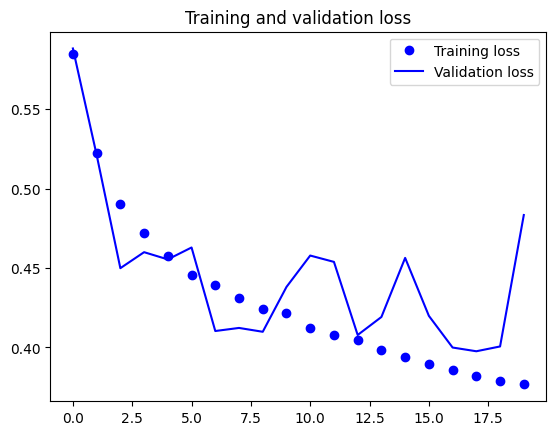

In [35]:
run_model(model4, "experiment4_feature_extraction", epochs=20)

67/67 [==============================] - 13s 165ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7065    0.7471    0.7263       696
           1     0.8740    0.8497    0.8617      1437

    accuracy                         0.8162      2133
   macro avg     0.7903    0.7984    0.7940      2133
weighted avg     0.8194    0.8162    0.8175      2133



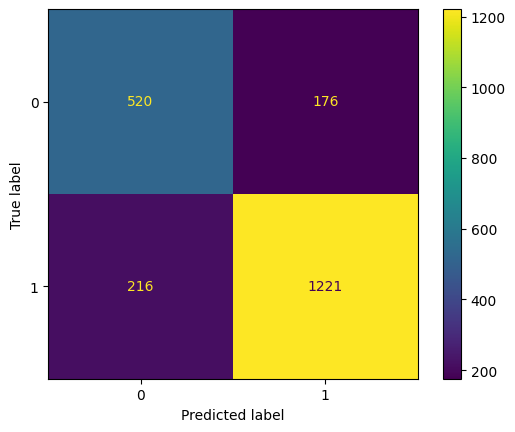

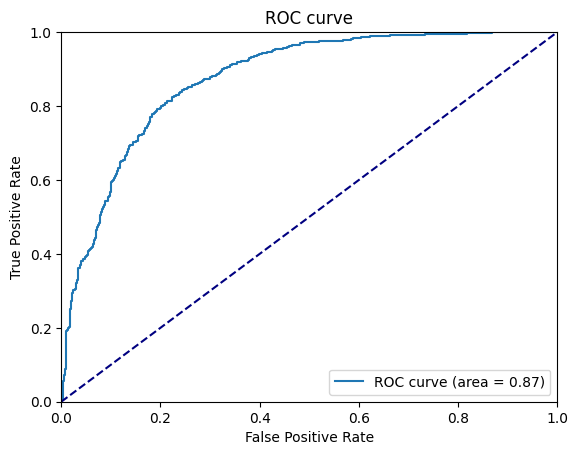

In [36]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5'))

### Experiment 5: global average pooling and two dense layers

In [37]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_4 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_4 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.6782
Epoch 1: val_loss improved from inf to 0.77345, saving model to /content/models/Experiment5_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 56s 244ms/step - loss: 0.6393 - accuracy: 0.6782 - val_loss: 0.7735 - val_accuracy: 0.6196
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5204 - accuracy: 0.7459
Epoch 2: val_loss improved from 0.77345 to 0.47807, saving model to /content/models/Experiment5_feature_extraction.h5
200/200 [==============================] - 46s 226ms/step - loss: 0.5204 - accuracy: 0.7459 - val_loss: 0.4781 - val_accuracy: 0.8002
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4816 - accuracy: 0.7659
Epoch 3: val_loss improved from 0.47807 to 0.41616, saving model to /content/models/Experiment5_feature_extraction.h5
200/200 [==============================] - 46s 231ms/step - loss: 0.4816 - accuracy: 0.7659 - val_loss: 0.4162 - val_accuracy: 0.8110
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4526 - accuracy: 0.7822
Epoch 4: val_loss improved from 0.41616 to 0.40411, saving model to /conte

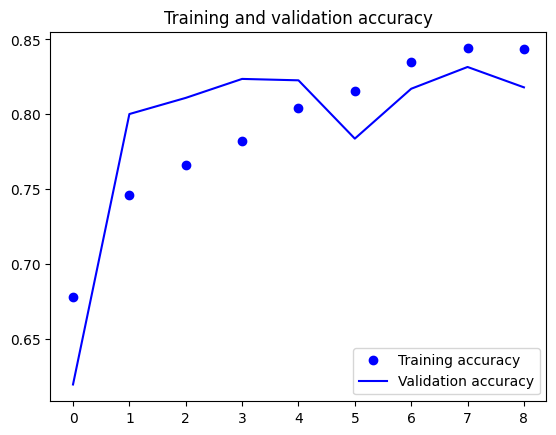

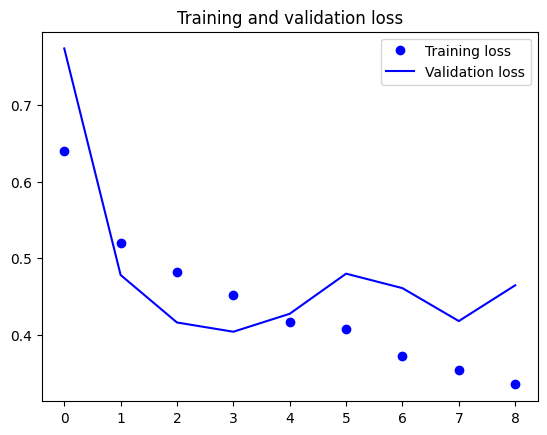

In [38]:
run_model(model5, 'Experiment5_feature_extraction', epochs=50)

67/67 [==============================] - 13s 159ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8281    0.6020    0.6972       696
           1     0.8297    0.9395    0.8812      1437

    accuracy                         0.8293      2133
   macro avg     0.8289    0.7707    0.7892      2133
weighted avg     0.8292    0.8293    0.8212      2133



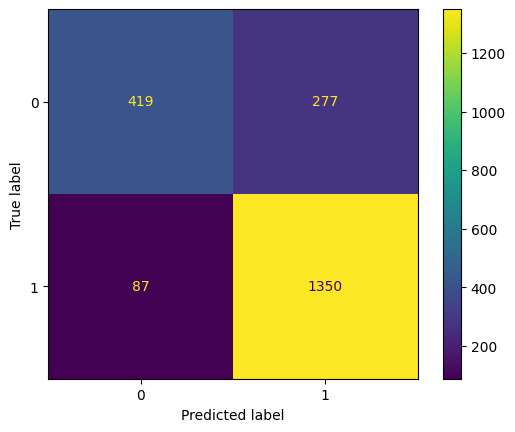

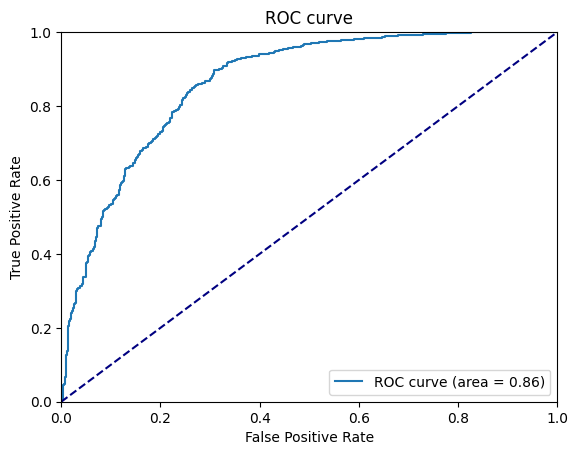

In [39]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5'))

## Fine-tuning

### Experiment 1: one dense layer

In [44]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5')

set_trainable = False
for layer in model1.get_layer('resnet101v2').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model1, learning_rate=1e-5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 64)                642259

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.5549 - accuracy: 0.8386
Epoch 1: val_loss improved from inf to 0.96799, saving model to /content/models/experiment1_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 60s 259ms/step - loss: 0.5549 - accuracy: 0.8386 - val_loss: 0.9680 - val_accuracy: 0.7397
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9417
Epoch 2: val_loss improved from 0.96799 to 0.87291, saving model to /content/models/experiment1_fine_tuning.h5
200/200 [==============================] - 59s 295ms/step - loss: 0.1510 - accuracy: 0.9417 - val_loss: 0.8729 - val_accuracy: 0.7725
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9801
Epoch 3: val_loss improved from 0.87291 to 0.87041, saving model to /content/models/experiment1_fine_tuning.h5
200/200 [==============================] - 51s 252ms/step - loss: 0.0722 - accuracy: 0.9801 - val_loss: 0.8704 - val_accuracy: 0.7777
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9931
Epoch 4: val_loss improved from 0.87041 to 0.86960, saving model to /content/models/expe

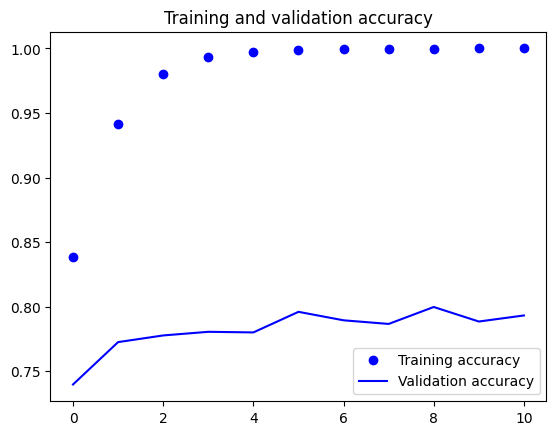

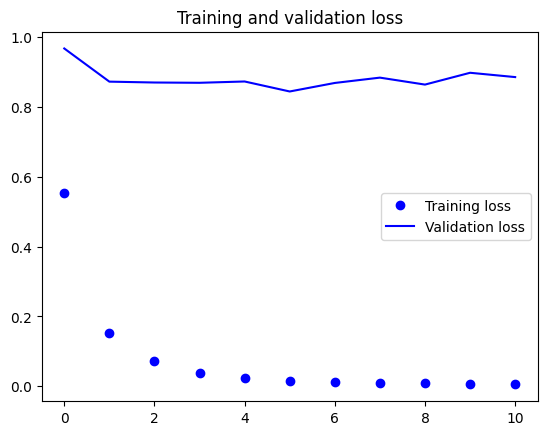

In [45]:
run_model(model1, "experiment1_fine_tuning", epochs=50)

67/67 [==============================] - 12s 161ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6261    0.7845    0.6964       696
           1     0.8810    0.7731    0.8236      1437

    accuracy                         0.7768      2133
   macro avg     0.7536    0.7788    0.7600      2133
weighted avg     0.7979    0.7768    0.7821      2133



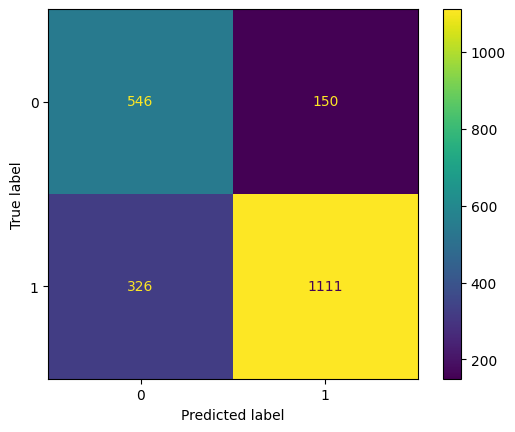

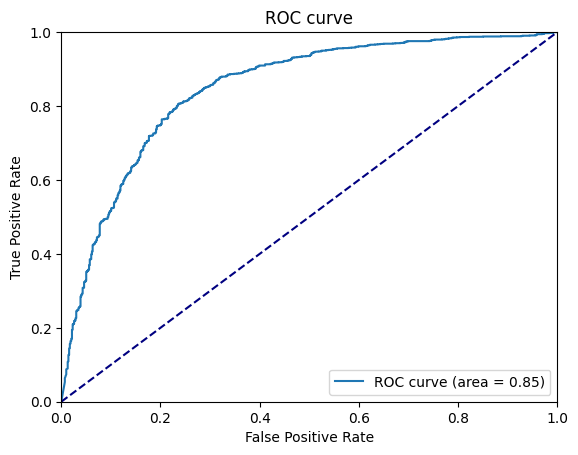

In [46]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_fine_tuning.h5'))

### Experiment 2: global average pooling

In [ ]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment4_feature_extraction.h5')

set_trainable = False
# fine-tune the last three elements
for layer in model4.get_layer('resnet101v2').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model4, learning_rate=1e-5)

In [ ]:
run_model(model4, "Experiment2_fine_tuning")

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_fine_tuning.h5'))

### Experiment 3: global average pooling and two dense layers

In [ ]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_feature_extraction.h5')

set_trainable = False
for layer in model5.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model5, "Experiment3_fine_tuning", epochs=50)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_fine_tuning.h5'))

## Remove final block (5-th block)
Due to Colab's limitations we only took part of the original dataset, so now our dataset is small and very different from the one the pre-trained network was trained on. In this case it may be good to try to remove some of the final layers of the pre-trained network whose filters deal with finding detailed features. We will use less specific features that we find in previous levels.

In [49]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [51]:
conv_base = keras.applications.ResNet101V2(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

Remove the last convolutionary block of ResNet50.

In [52]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv4_block6_out')].output, name='base')
base.trainable = False
base.summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_13[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                               

### Feature extraction
Firstly, we will try to use the new base network to extract the features; we will put a classifier on top of the base network. We couldn't afford to use the Flatten, the output of the base network is 14x14x1024, too much. So we decided to use the GlobalAveragePooling2D.

#### Experiment 1: one dense layer with 256 neurons
In this first example we use just a Dense layer before the output layer.

In [53]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_7 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_7 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_2  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.6033 - accuracy: 0.6950
Epoch 1: val_loss improved from inf to 0.47775, saving model to /content/models/Experiment1_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 31s 141ms/step - loss: 0.6033 - accuracy: 0.6950 - val_loss: 0.4778 - val_accuracy: 0.7753
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.7550
Epoch 2: val_loss improved from 0.47775 to 0.45019, saving model to /content/models/Experiment1_remove_blocks_feature_extraction.h5
200/200 [==============================] - 22s 110ms/step - loss: 0.5118 - accuracy: 0.7550 - val_loss: 0.4502 - val_accuracy: 0.7974
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.7645
Epoch 3: val_loss did not improve from 0.45019
200/200 [==============================] - 23s 113ms/step - loss: 0.4880 - accuracy: 0.7645 - val_loss: 0.4840 - val_accuracy: 0.7575
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.7716
Epoch 4: val_loss improved from 0.45019 to 0.39319, saving model to /content/models/Experiment1_remove_blocks_feature_extraction.h5

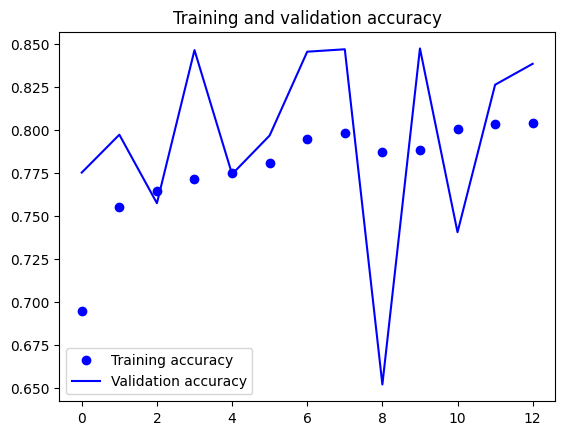

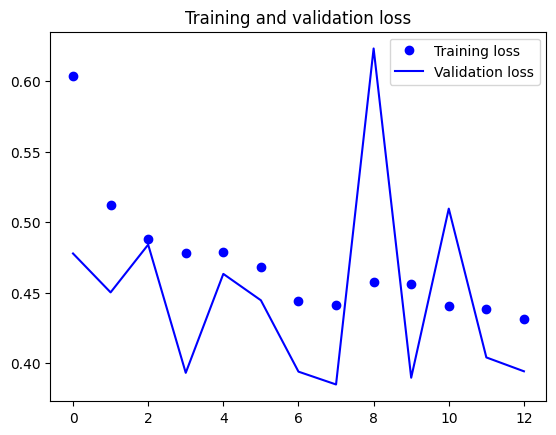

In [54]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction", epochs=30)

67/67 [==============================] - 6s 82ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7373    0.7701    0.7533       696
           1     0.8862    0.8671    0.8765      1437

    accuracy                         0.8354      2133
   macro avg     0.8117    0.8186    0.8149      2133
weighted avg     0.8376    0.8354    0.8363      2133



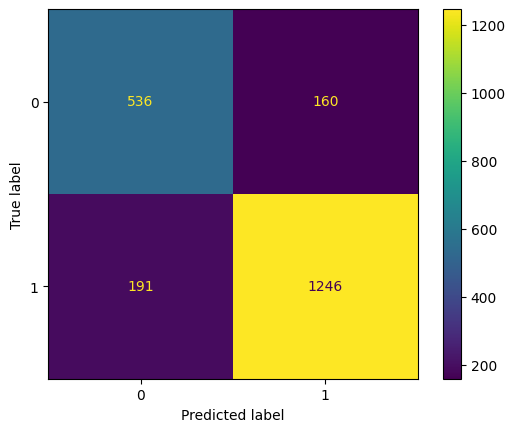

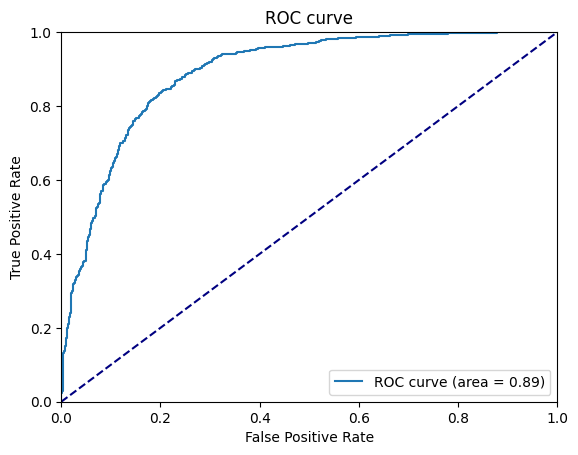

In [55]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction.h5'))

#### Experiment 2: one dense layer with 256 neurons and dropout
Try to use Dropout.

In [56]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.6731
Epoch 1: val_loss improved from inf to 0.44530, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 27s 114ms/step - loss: 0.6479 - accuracy: 0.6731 - val_loss: 0.4453 - val_accuracy: 0.8194
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.7387
Epoch 2: val_loss improved from 0.44530 to 0.43366, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5
200/200 [==============================] - 23s 112ms/step - loss: 0.5403 - accuracy: 0.7387 - val_loss: 0.4337 - val_accuracy: 0.8133
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.7509
Epoch 3: val_loss did not improve from 0.43366
200/200 [==============================] - 22s 110ms/step - loss: 0.5189 - accuracy: 0.7509 - val_loss: 0.6812 - val_accuracy: 0.6159
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7550
Epoch 4: val_loss improved from 0.43366 to 0.42372, saving model to /content/models/Experiment2_remove_blocks_feature_extraction.h5

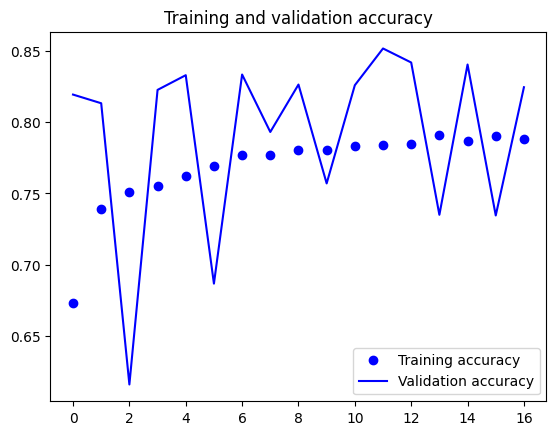

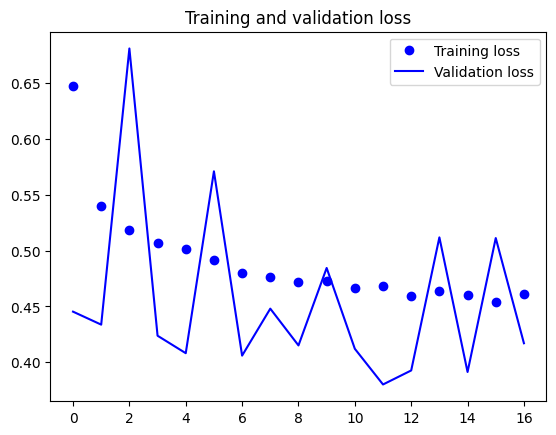

In [57]:
run_model(model2, "Experiment2_remove_blocks_feature_extraction")

67/67 [==============================] - 6s 77ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8090    0.6940    0.7471       696
           1     0.8613    0.9207    0.8900      1437

    accuracy                         0.8467      2133
   macro avg     0.8352    0.8073    0.8186      2133
weighted avg     0.8443    0.8467    0.8434      2133



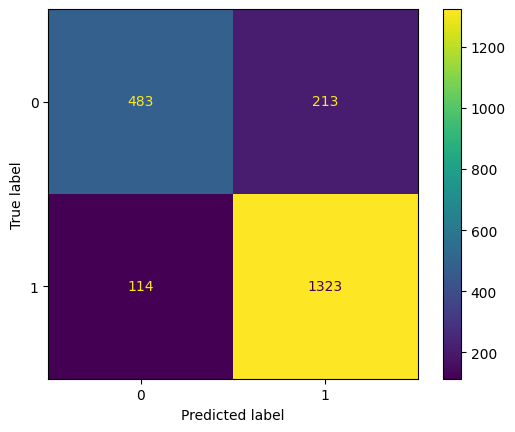

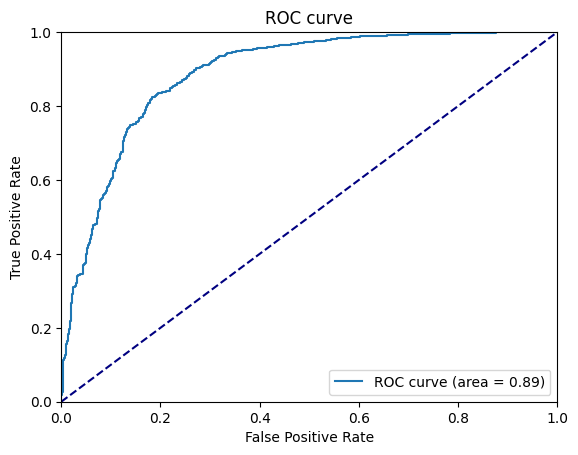

In [58]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5'))

#### Experiment 3: two dense layers, 256-128 neurons
Try to make a more complex network, increasing the dense layers.

In [59]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dense(128)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_9 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_4  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.6992
Epoch 1: val_loss improved from inf to 0.61245, saving model to /content/models/Experiment3_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 27s 117ms/step - loss: 0.6042 - accuracy: 0.6992 - val_loss: 0.6124 - val_accuracy: 0.6360
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.7728
Epoch 2: val_loss did not improve from 0.61245
200/200 [==============================] - 22s 109ms/step - loss: 0.4906 - accuracy: 0.7728 - val_loss: 0.9706 - val_accuracy: 0.4231
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 0.5024 - accuracy: 0.7534
Epoch 3: val_loss improved from 0.61245 to 0.49581, saving model to /content/models/Experiment3_remove_blocks_feature_extraction.h5
200/200 [==============================] - 27s 134ms/step - loss: 0.5024 - accuracy: 0.7534 - val_loss: 0.4958 - val_accuracy: 0.7439
Epoch 4/20
200/200 [==============================] - ETA: 0s - loss: 0.4759 - accuracy: 0.7738
Epoch 4: val_loss improved from 0.49581 to 0.44036, saving model to /content/models/Experiment3_remove_blocks_feature_extraction.h5

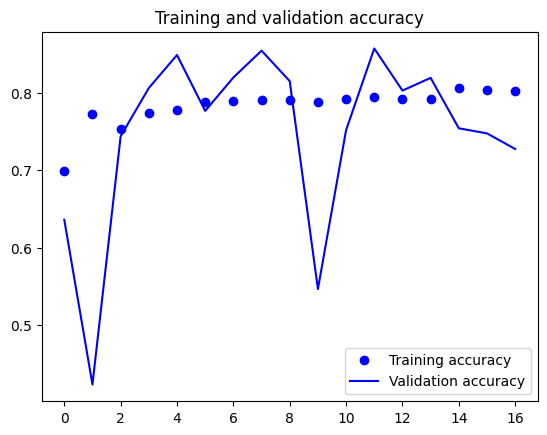

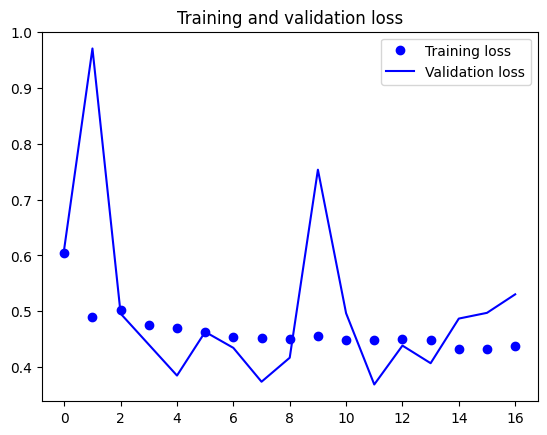

In [60]:
run_model(model3, "Experiment3_remove_blocks_feature_extraction")

67/67 [==============================] - 6s 81ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7897    0.7284    0.7578       696
           1     0.8732    0.9061    0.8893      1437

    accuracy                         0.8481      2133
   macro avg     0.8315    0.8173    0.8236      2133
weighted avg     0.8460    0.8481    0.8464      2133



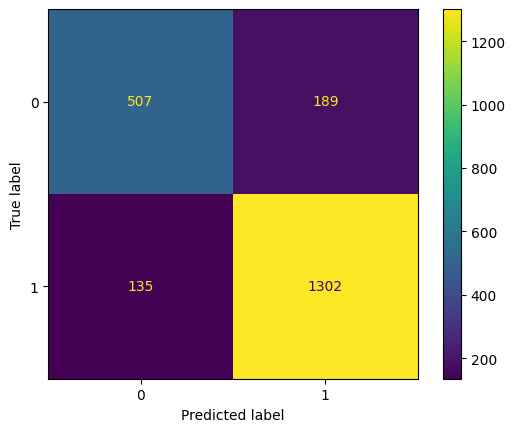

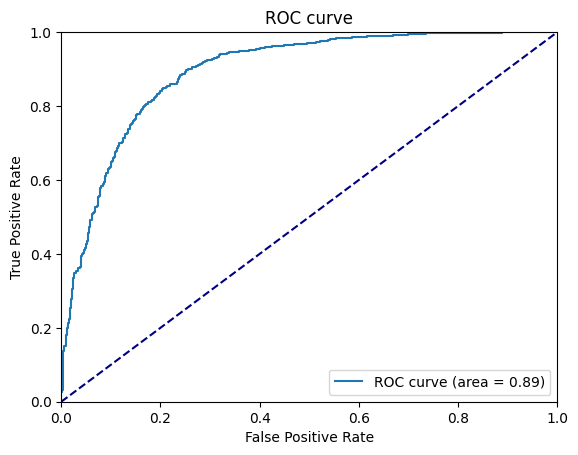

In [61]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_feature_extraction.h5'))

#### Experiment 4: one dense layer with 512 neurons
Try to make a more complex networks increasing the neurons of a single Dense layer. We use RMSprop that in this case give us a smoother learning curve.

In [62]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4, optimizer='rmsprop', learning_rate=5e-5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6232 - accuracy: 0.6628
Epoch 1: val_loss improved from inf to 0.59793, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 26s 115ms/step - loss: 0.6232 - accuracy: 0.6628 - val_loss: 0.5979 - val_accuracy: 0.6773
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5616 - accuracy: 0.7189
Epoch 2: val_loss did not improve from 0.59793
200/200 [==============================] - 22s 108ms/step - loss: 0.5616 - accuracy: 0.7189 - val_loss: 0.6585 - val_accuracy: 0.5896
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.7408
Epoch 3: val_loss improved from 0.59793 to 0.49502, saving model to /content/models/Experiment4_remove_blocks_feature_extraction.h5
200/200 [==============================] - 27s 136ms/step - loss: 0.5376 - accuracy: 0.7408 - val_loss: 0.4950 - val_accuracy: 0.7749
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.7489
Epoch 4: val_loss did not improve from 0.49502
200/200 [==============================] - 22s 109ms/step - loss: 0.5214 - accuracy:

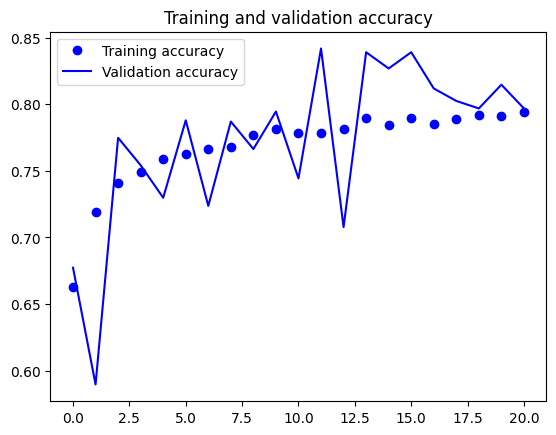

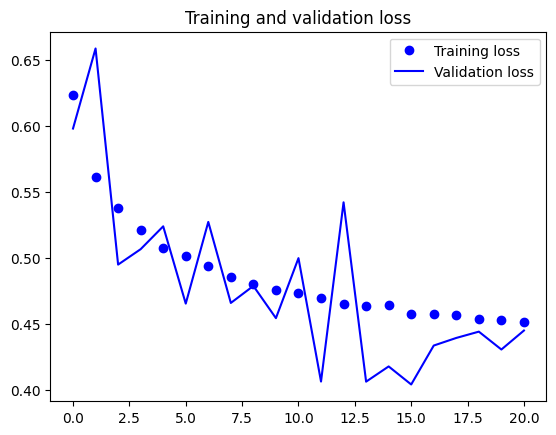

In [63]:
run_model(model4, "Experiment4_remove_blocks_feature_extraction", epochs=50)

67/67 [==============================] - 6s 79ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7486    0.7443    0.7464       696
           1     0.8765    0.8789    0.8777      1437

    accuracy                         0.8350      2133
   macro avg     0.8125    0.8116    0.8120      2133
weighted avg     0.8347    0.8350    0.8349      2133



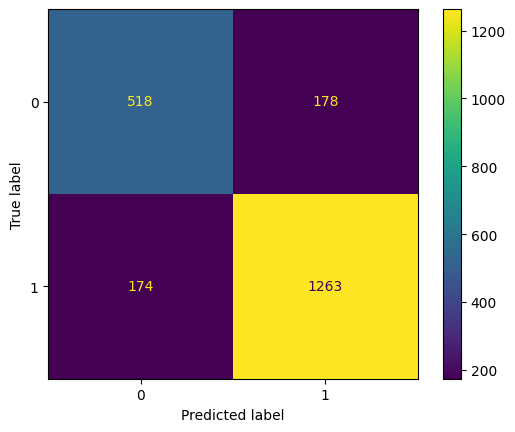

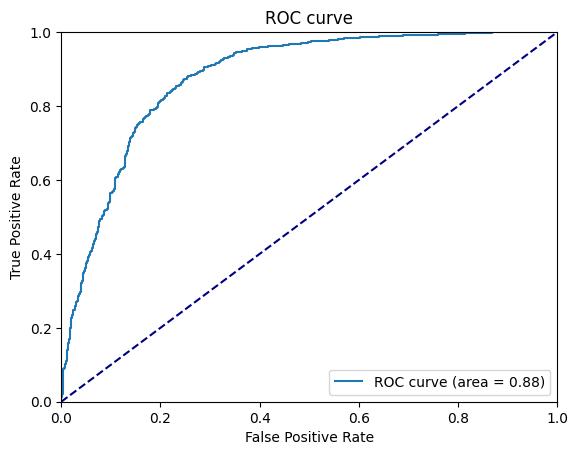

In [64]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5'))

#### Experiment 5: two dense layers of 512 neurons
Try to make a more complex networks with two fully-connected dense layer of 512 neurons. We use RMSprop that in this case give us a smoother learning curve.

In [65]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet_v2.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model5 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model5, optimizer='rmsprop')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_11 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_11 (TFOpL  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_6  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.6467
Epoch 1: val_loss improved from inf to 0.56564, saving model to /content/models/Experiment5_remove_blocks_feature_extraction.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 26s 115ms/step - loss: 0.6473 - accuracy: 0.6467 - val_loss: 0.5656 - val_accuracy: 0.6754
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7167
Epoch 2: val_loss improved from 0.56564 to 0.47368, saving model to /content/models/Experiment5_remove_blocks_feature_extraction.h5
200/200 [==============================] - 23s 112ms/step - loss: 0.5563 - accuracy: 0.7167 - val_loss: 0.4737 - val_accuracy: 0.8096
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5239 - accuracy: 0.7403
Epoch 3: val_loss improved from 0.47368 to 0.44343, saving model to /content/models/Experiment5_remove_blocks_feature_extraction.h5
200/200 [==============================] - 23s 112ms/step - loss: 0.5239 - accuracy: 0.7403 - val_loss: 0.4434 - val_accuracy: 0.8204
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.7561
Epoch 4: val_loss did not improve from 0.44343

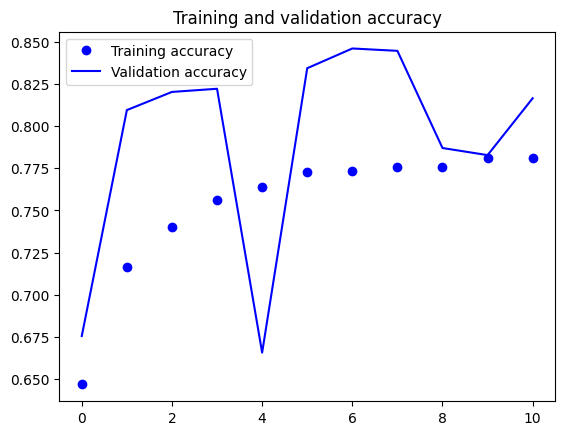

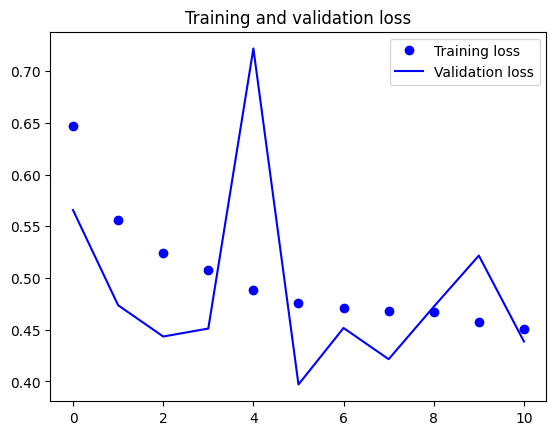

In [66]:
run_model(model5, "Experiment5_remove_blocks_feature_extraction", epochs=50)

67/67 [==============================] - 7s 84ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8852    0.5761    0.6980       696
           1     0.8244    0.9638    0.8887      1437

    accuracy                         0.8373      2133
   macro avg     0.8548    0.7700    0.7933      2133
weighted avg     0.8442    0.8373    0.8265      2133



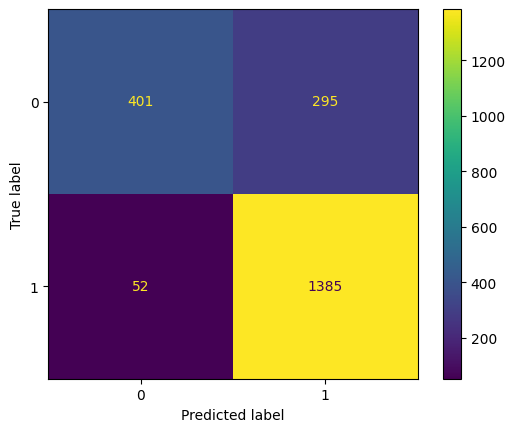

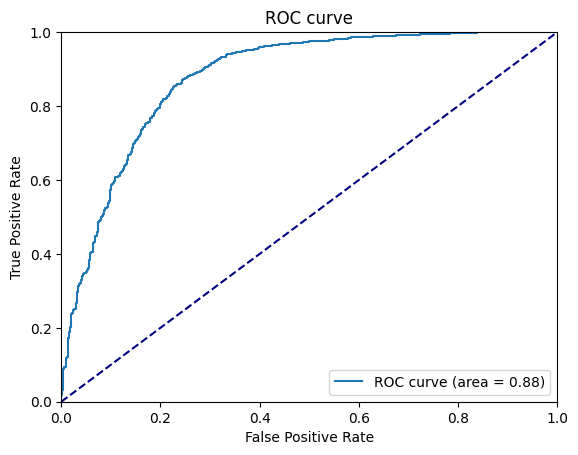

In [67]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5'))

### Fine tuning
Now we can fine tune the best models of the previous experiments, unfreezing some of the last layers of the base network.

#### Unfreeze some layers
Firstly, we try to unfreeze just some of the last layers of the fourth block.

##### Experiment 1: one dense layer with 256 neurons and dropout

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

In [ ]:
compile_model(model1, learning_rate=1e-5)

In [ ]:
run_model(model1, 'Experiment1_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning.h5'))

##### Experiment 2: one dense layer with 512 neurons

In [ ]:
model2 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
# set trainable from "conv4_block6_1_conv"
for layer in model2.get_layer('base').layers:
    if layer.name == 'conv4_block6_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
model1.summary()

In [ ]:
compile_model(model2, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model2, 'Experiment2_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the 4-th block
We try to unfreeze more layers, more precisely all the fourth block (that is the last block of our base network).

##### Experiment 3: one dense layer with 256 neurons and dropout

In [ ]:
model3 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
# set trainable all conv4 section
for layer in model3.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
compile_model(model3, learning_rate=1e-5)

In [ ]:
run_model(model3, 'Experiment3_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment3_remove_blocks_fine_tuning.h5'))

##### Experiment 4: one dense layer with 512 neurons

In [ ]:
model4 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model4.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model4, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model4, 'Experiment4_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_fine_tuning.h5'))

##### Experiment 5: two dense layers of 512 neurons

In [ ]:
model5 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
set_trainable = False
for layer in model5.get_layer('base').layers:
    if layer.name == 'conv4_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model5, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model5, 'Experiment5_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the third block
We saw an improvement of our models, so we keep to unfreeze more layers. Now we unfreeze also the third block of our base network.

##### Experiment 6: one dense layer with 256 neurons and dropout

In [ ]:
model6 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model6.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model6, learning_rate=1e-5)

In [ ]:
run_model(model6, 'Experiment6_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment6_remove_blocks_fine_tuning.h5'))

##### Experiment 7: one dense layer with 512 neurons

In [ ]:
model7 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model7.get_layer('base').layers:
    if layer.name == 'conv3_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model7, optimizer='rmsprop', learning_rate=1e-5)

In [ ]:
run_model(model7, 'Experiment7_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment7_remove_blocks_fine_tuning.h5'))

#### Unfreeze also the second block
We try to unfreeze also the entire second block

##### Experiment 8: one dense layer with 256 neurons and dropout

In [68]:
model8 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model8.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model8, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4952 - accuracy: 0.7842
Epoch 1: val_loss improved from inf to 0.35527, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 79s 284ms/step - loss: 0.4952 - accuracy: 0.7842 - val_loss: 0.3553 - val_accuracy: 0.8490
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.3542 - accuracy: 0.8466
Epoch 2: val_loss improved from 0.35527 to 0.29101, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5
200/200 [==============================] - 53s 263ms/step - loss: 0.3542 - accuracy: 0.8466 - val_loss: 0.2910 - val_accuracy: 0.8790
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.8759
Epoch 3: val_loss improved from 0.29101 to 0.25577, saving model to /content/models/Experiment8_remove_blocks_fine_tuning.h5
200/200 [==============================] - 54s 270ms/step - loss: 0.2900 - accuracy: 0.8759 - val_loss: 0.2558 - val_accuracy: 0.8963
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.2488 - accuracy: 0.8959
Epoch 4: val_loss improved from 0.25577 to 0.24690, saving m

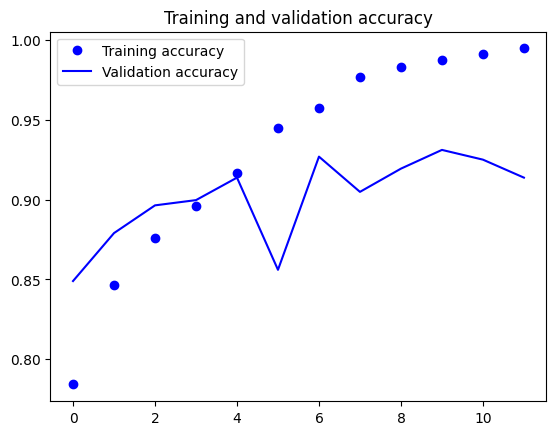

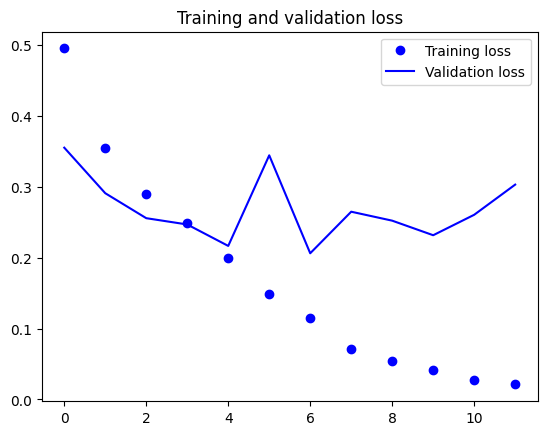

In [69]:
run_model(model8, 'Experiment8_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 6s 81ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8899    0.8707    0.8802       696
           1     0.9380    0.9478    0.9429      1437

    accuracy                         0.9226      2133
   macro avg     0.9139    0.9092    0.9115      2133
weighted avg     0.9223    0.9226    0.9224      2133



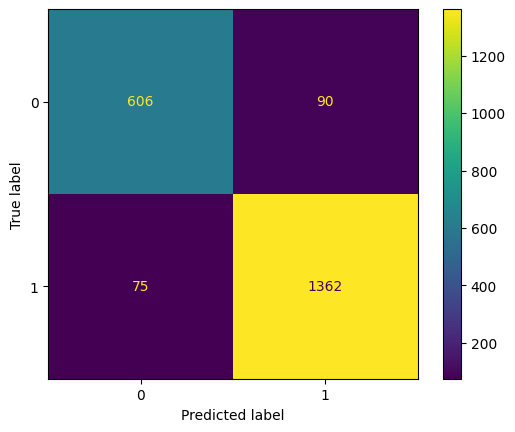

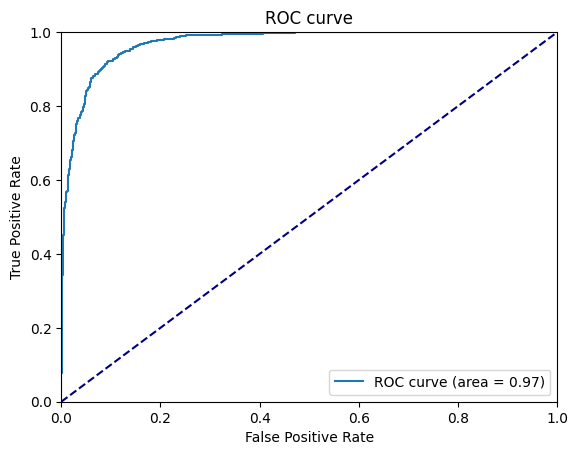

In [70]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment8_remove_blocks_fine_tuning.h5'))

##### Experiment 9: one dense layer with 512 neurons

In [71]:
model9 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')

set_trainable = False
for layer in model9.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model9, learning_rate=1e-5)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_10 (TFOpL  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_5  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.4862 - accuracy: 0.7861
Epoch 1: val_loss improved from inf to 0.36673, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 73s 276ms/step - loss: 0.4862 - accuracy: 0.7861 - val_loss: 0.3667 - val_accuracy: 0.8457
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.3493 - accuracy: 0.8480
Epoch 2: val_loss improved from 0.36673 to 0.29370, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5
200/200 [==============================] - 54s 269ms/step - loss: 0.3493 - accuracy: 0.8480 - val_loss: 0.2937 - val_accuracy: 0.8809
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8766
Epoch 3: val_loss improved from 0.29370 to 0.27706, saving model to /content/models/Experiment9_remove_blocks_fine_tuning.h5
200/200 [==============================] - 52s 261ms/step - loss: 0.2886 - accuracy: 0.8766 - val_loss: 0.2771 - val_accuracy: 0.8917
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9051
Epoch 4: val_loss improved from 0.27706 to 0.23642, saving m

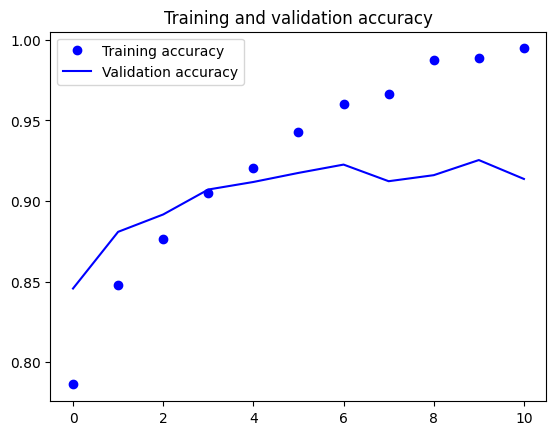

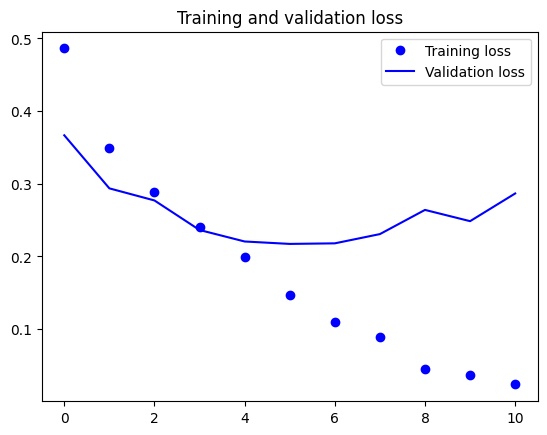

In [72]:
run_model(model9, 'Experiment9_remove_blocks_fine_tuning', epochs=30)

67/67 [==============================] - 6s 81ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.8228    0.9009    0.8601       696
           1     0.9497    0.9061    0.9274      1437

    accuracy                         0.9044      2133
   macro avg     0.8863    0.9035    0.8937      2133
weighted avg     0.9083    0.9044    0.9054      2133



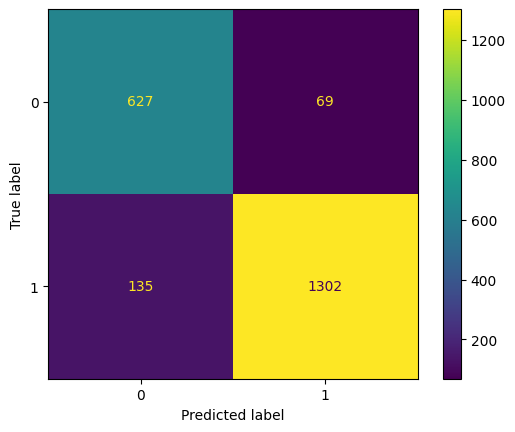

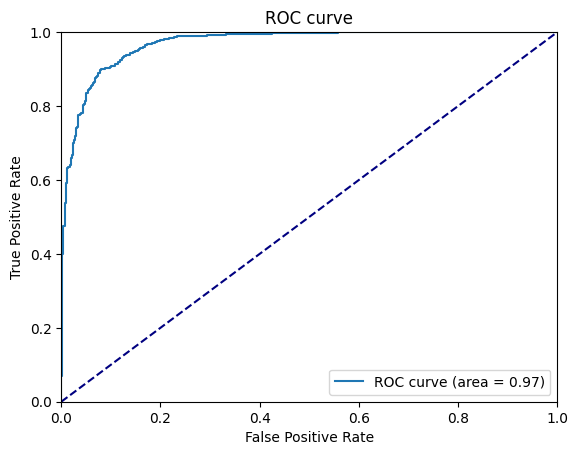

In [73]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment9_remove_blocks_fine_tuning.h5'))

#### Unfreeze all the base network
Let's try to unfreeze all the layers of the base network

##### Experiment 10: one dense layer with 256 neurons and dropout

In [74]:
model10 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment2_remove_blocks_feature_extraction.h5')
model10.trainable = True
compile_model(model10, learning_rate=1e-5)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_8 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 base (Functional)           (None, 14, 14, 1024)      8573440   
                                                                 
 global_average_pooling2d_3  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                           

In [ ]:
run_model(model10, 'Experiment10_remove_blocks_fine_tuning', epochs=30)

Epoch 1/30


In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment10_remove_blocks_fine_tuning.h5'))

##### Experiment 11: one dense layer with 512 neurons

In [ ]:
model11 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_remove_blocks_feature_extraction.h5')
model11.trainable = True
compile_model(model11, learning_rate=1e-5)

In [ ]:
run_model(model11, 'Experiment11_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment11_remove_blocks_fine_tuning.h5'))

##### Experiment 12: two dense layers of 512 neurons

In [ ]:
model12 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment5_remove_blocks_feature_extraction.h5')
model12.trainable = True
compile_model(model12, learning_rate=1e-5)

In [ ]:
run_model(model12, 'Experiment12_remove_blocks_fine_tuning', epochs=30)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment12_remove_blocks_fine_tuning.h5'))

# CLAHE
We will try now to use the dataset in which the images are preprocesses with CLAHE. We will test the performance with the best network previuosly found and we will compare the results. Unfortunately, no significant improvements were found.

## Load dataset from Google Drive
The dataset is stored in Google Drive in a zip file, we unzip it locally for better performance.

In [ ]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/SplittedDataset_CLAHE.zip" -d "/content"

## Set parameters

In [ ]:
DATASET_PATH = "/content/SplittedDataset_CLAHE"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

## Load dataset
The dataset, properly preprocessed, is now located in the local machine.

In [ ]:
set_seed()

train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

## Remove final block
As we did for the original dataset, here too we are going to remove the last block that deals with the high-level features of Imagenet

In [ ]:
conv_base = keras.applications.resnet.ResNet50(include_top = False, weights='imagenet', input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3))

In [ ]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'conv4_block6_out')].output, name='base')
base.trainable = False
base.summary()

## Feature extraction
Firstly, we try the simplest approach in which we use the pretrained network to extract feature and we use our classifier to classify the images.

### Experiment 1: one dense layer with 256 neurons and dropout
This is the first best model found in the previous section with the standard dataset.

In [ ]:
# define the classifier
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = keras.applications.resnet50.preprocess_input(inputs)
x = base(x)
x = layers.GlobalAveragePooling2D() (x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

In [ ]:
run_model(model1, "Experiment1_remove_blocks_feature_extraction_CLAHE", epochs=50)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction_CLAHE.h5'))

## Fine Tuning
Now we can fine-tune the base network to adapt it to extract more useful features in our images.

### Unfreeze up to the second block included
We tried directly to unfreeze up to the second block included, just to compare with the previous results. We can easily see that unfortunately there are no significative improvements, indeed the results are less satisfactory than the same network on the original dataset.

#### Experiment 1: one dense layer with 256 neurons and dropout

In [ ]:
model1 = tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_feature_extraction_CLAHE.h5')

set_trainable = False
for layer in model1.get_layer('base').layers:
    if layer.name == 'conv2_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
compile_model(model1, learning_rate=1e-5)

In [ ]:
run_model(model1, "Experiment1_remove_blocks_fine_tuning_CLAHE", epochs=50)

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment1_remove_blocks_fine_tuning_CLAHE.h5'))